<a href="https://colab.research.google.com/github/pranay8297/fastaip2/blob/main/DDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [ ]:
!pip install torch==2.1.0
!pip install datasets
# !pip install torchaudio==0.13.1
!pip install ipdb
!pip install torcheval
!pip install -Uqq git+https://github.com/fastai/course22p2
!pip install wandb
!pip install diffusers
!pip install tqdm

In [14]:
from miniai.datasets import *
from miniai.activations import *
from miniai.learner import *
from miniai.augment import *
from miniai.activations import *
from miniai.init import *

from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_tensor, resize

import torch
import math

from torch import nn
from torch.nn import functional as F
from torcheval.metrics import MulticlassAccuracy
import fastcore.all as fc
import matplotlib as mpl, matplotlib.pyplot as plt
from ipdb import set_trace as st
from functools import partial
from torch import optim
from torch.optim import lr_scheduler
import wandb

from torchvision import transforms
from torchvision.transforms import v2
from diffusers import UNet2DModel
from pathlib import Path
from tqdm import tqdm

mdl_path = Path('drive/MyDrive/fastai_p2/models/')

In [4]:
from google.colab import drive
drive.mount('/content/drive')
mpl.rcParams['image.cmap'] = 'gray'
set_seed(42)

Mounted at /content/drive


In [5]:
dsd = load_dataset('fashion_mnist')

@inplace
def transformi(b): b['image'] = [resize(to_tensor(o), (32, 32), antialias = True) for o in b['image']]

def collate_fn(some_data):
  sd = (i.values() for i in some_data)
  xs, ys = zip(*sd)
  return torch.stack(xs), torch.tensor(ys)

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, 128, num_workers=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [8]:
def noisify_img(cb_obj, x_0):
  n = x_0.shape[0]
  device = x_0.device
  noise = torch.randn(x_0.shape, device = device)
  ts = torch.randint(0, cb_obj.n_steps, size = (n,), device = device, dtype = torch.long)

  if cb_obj.alpha_bar.device != device: cb_obj.alpha_bar = cb_obj.alpha_bar.to(device)

  c1 = cb_obj.alpha_bar[ts].sqrt()[:, None, None, None].to(device)
  c2 = (1 - cb_obj.alpha_bar[ts]).sqrt()[:, None, None, None].to(device)
  x_t = c1*x_0 + c2*noise

  return (x_t, ts), noise

class DDPMPrep(Callback):
  def __init__(self, n_steps = 1000, beta_min = 0.0001, beta_max = 0.02):
    fc.store_attr()
    self.beta = torch.linspace(beta_min, beta_max, n_steps)
    self.alpha = 1. - self.beta
    self.alpha_bar = self.alpha.cumprod(0)
    self.sigma = self.beta.sqrt()

  def before_batch(self, learn): learn.batch = noisify_img(self, learn.batch[0])

class UnetModel(UNet2DModel):
  def forward(self, x): return super().forward(*x).sample

class BaseSchedulerCB(Callback):
  def __init__(self, sched_class): self.sched_class = sched_class
  def before_fit(self, learn): self.sched = self.sched_class(learn.opt)
  def step(self, learn):
    if not learn.training: return
    self.sched.step()

class BatchSchedulerCB(BaseSchedulerCB):
  def __init__(self, sched_class):super().__init__(sched_class)
  def after_batch(self, learn): self.step(learn)

def get_callbacks(stats_layer = GeneralRelu):
  astats = ActivationStats(fc.risinstance(stats_layer))
  metrics = MetricsCB()
  return [DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), metrics, ProgressCB(plot = True), astats]

class LossMonitoringCB(Callback):
  def __init__(self): self.losses = [4.0]
  def after_loss(self, learn):
    if not learn.training: return
    if learn.loss.item() > self.losses[-1] * 2:
      print('SOME SHIT HAPPENED')
      st()
    self.losses.append(learn.loss.item())


In [ ]:
# dls = DataLoaders.from_dd(tds, 128, num_workers=2)

# Experiments in Playground

In [ ]:
x = torch.randn((4, 1, 32, 32))
n = torch.randn(x.shape)
ts = torch.randint(size = (4,), low = 0, high = 10)

beta = torch.linspace(0.1, 1, 10)
alpha = 1. - beta
alpha_bar = alpha.cumprod(0)

In [ ]:
alpha_bar.shape

torch.Size([10])

In [ ]:
ts

tensor([1, 5, 6, 4])

In [ ]:
c1 = alpha_bar[ts].sqrt()
c2 = (1. - alpha_bar[ts]).sqrt()

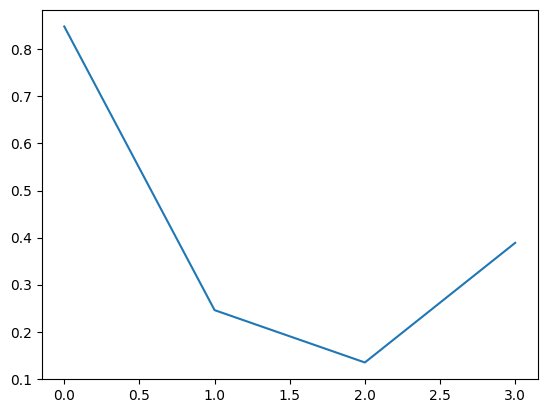

In [ ]:
plt.plot(c1)

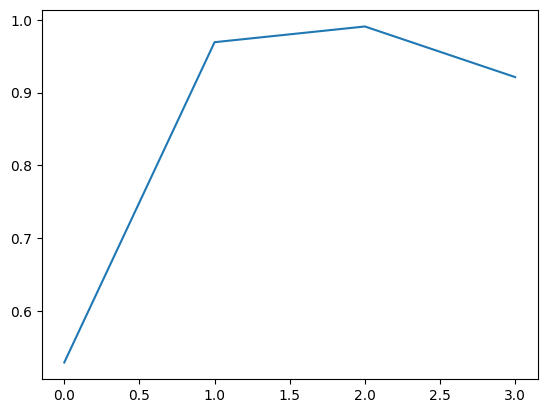

In [ ]:
plt.plot(c2)

In [ ]:
c1.shape

torch.Size([4])

In [ ]:
x.shape

torch.Size([4, 1, 32, 32])

In [ ]:
c1[:, None, None, None].shape

torch.Size([4, 1, 1, 1])

In [ ]:
c1[:, None, None, None] *

tensor([[[[0.8485]]],


        [[[0.2459]]],


        [[[0.1347]]],


        [[[0.3888]]]])

In [ ]:
x.shape

torch.Size([4, 1, 32, 32])

In [ ]:
x.mean((1, 2, 3)), x.std((1, 2, 3))

(tensor([-0.0070, -0.0118, -0.0779, -0.0054]),
 tensor([0.9981, 0.9988, 1.0180, 1.0242]))

In [ ]:
x_bar =

In [ ]:
x_bar.mean((1, 2, 3)), x_bar.std((1, 2, 3))

(tensor([-0.0060, -0.0029, -0.0105, -0.0021]),
 tensor([0.8469, 0.2456, 0.1371, 0.3983]))

In [ ]:
noise = torch.randn(x.shape)

In [ ]:
noise.mean(), noise.std()

(tensor(0.0049), tensor(0.9886))

In [ ]:
noise[2].mean(), noise[2].std()

(tensor(-0.0003), tensor(1.0068))

In [ ]:
x_bar = c1[:, None, None, None] * x + c2[:, None, None, None] * noise

In [ ]:
x_bar.shape

torch.Size([4, 1, 32, 32])

In [ ]:
x_bar.mean((1, 2, 3)), x_bar.std((1, 2, 3))

(tensor([ 0.0040,  0.0121, -0.0107, -0.0156]),
 tensor([0.9898, 0.9885, 1.0087, 1.0106]))

In [ ]:
x, y = next(iter(dls.train))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

In [ ]:
x.shape

torch.Size([128, 1, 32, 32])

In [ ]:
x = x[2]

<Axes: >

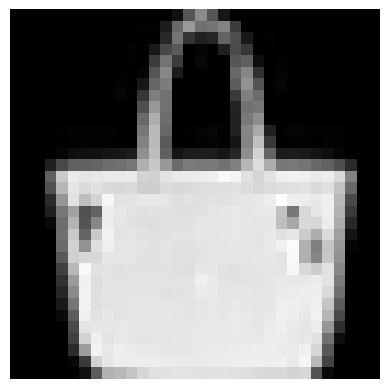

In [ ]:
show_image(x)

In [ ]:
xs = torch.cat([x]*16, dim = 0)[:, None, :, :]

In [ ]:
xs.shape

torch.Size([16, 1, 32, 32])

In [ ]:
n = torch.randn(xs.shape)
ts = torch.randint(size = (16,), low = 0, high = 1000)

beta = torch.linspace(0.0001, 0.02, 1000)
alpha = 1. - beta
alpha_bar = alpha.cumprod(0)

In [ ]:
ts

tensor([805, 790, 521, 822, 628, 780, 364, 464,  56,  91,  14, 303, 321, 736,
        244, 873])

In [ ]:
c1 = alpha_bar[ts].sqrt()
c2 = (1. - alpha_bar[ts]).sqrt()

In [ ]:
x_bar = c1[:, None, None, None] * xs + c2[:, None, None, None] * n

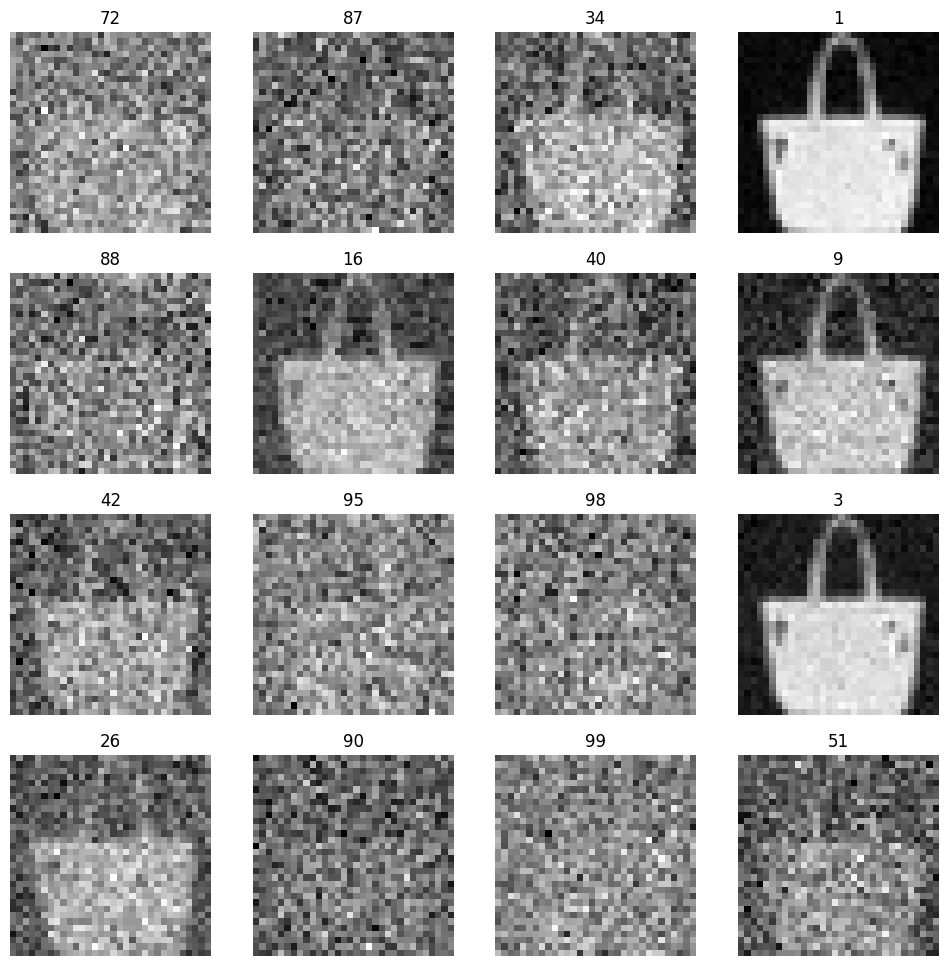

In [ ]:
show_images(x_bar, titles = [str(int(i)) for i in ts])

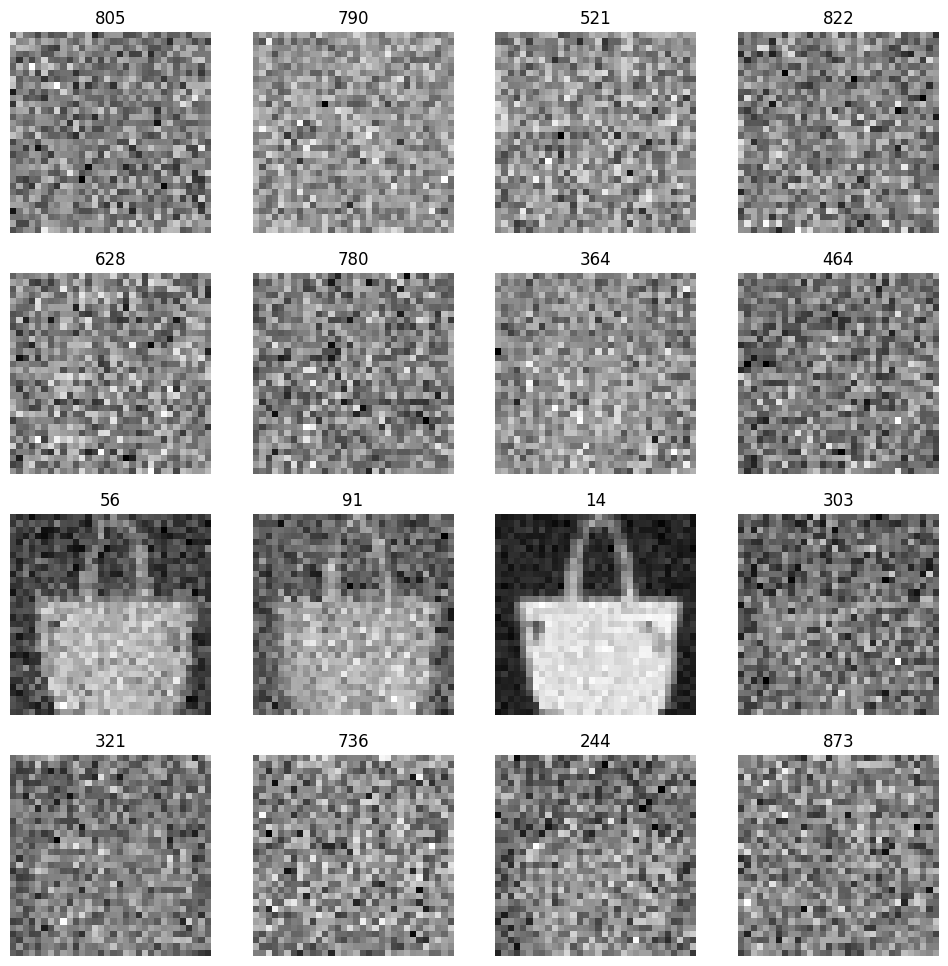

In [ ]:
show_images(x_bar, titles = [str(int(i)) for i in ts])

# Training

In [ ]:
def noisify_img(cb_obj, x_0):
  n = x_0.shape[0]
  device = x_0.device
  noise = torch.randn(x_0.shape, device = device)
  ts = torch.randint(0, cb_obj.n_steps, size = (n,), device = device, dtype = torch.long)

  if cb_obj.alpha_bar.device != device: cb_obj.alpha_bar = cb_obj.alpha_bar.to(device)

  c1 = cb_obj.alpha_bar[ts].sqrt()[:, None, None, None].to(device)
  c2 = (1 - cb_obj.alpha_bar[ts]).sqrt()[:, None, None, None].to(device)
  x_t = c1*x_0 + c2*noise

  return (x_t, ts), noise

In [ ]:
class DDPMPrep(Callback):
  def __init__(self, n_steps = 1000, beta_min = 0.0001, beta_max = 0.02):
    fc.store_attr()
    self.beta = torch.linspace(beta_min, beta_max, n_steps)
    self.alpha = 1. - self.beta
    self.alpha_bar = self.alpha.cumprod(0)
    self.sigma = self.beta.sqrt()

  def before_batch(self, learn): learn.batch = noisify_img(self, learn.batch[0])

In [ ]:
class UnetModel(UNet2DModel):
  def forward(self, x): return super().forward(*x).sample

In [ ]:
class BaseSchedulerCB(Callback):
  def __init__(self, sched_class): self.sched_class = sched_class
  def before_fit(self, learn): self.sched = self.sched_class(learn.opt)
  def step(self, learn):
    if not learn.training: return
    self.sched.step()

class BatchSchedulerCB(BaseSchedulerCB):
  def __init__(self, sched_class):super().__init__(sched_class)
  def after_batch(self, learn): self.step(learn)

def get_callbacks(stats_layer = GeneralRelu):
  astats = ActivationStats(fc.risinstance(stats_layer))
  metrics = MetricsCB()
  return [DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), metrics, ProgressCB(plot = True), astats]

In [ ]:
class LossMonitoringCB(Callback):
  def __init__(self): self.losses = [4.0]
  def after_loss(self, learn):
    if not learn.training: return
    if learn.loss.item() > self.losses[-1] * 2:
      print('SOME SHIT HAPPENED')
      st()
    self.losses.append(learn.loss.item())


In [ ]:
model = UnetModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128))
lr_max, epochs = 5e-03, 5
cbs = get_callbacks(nn.BatchNorm2d) + [
          DDPMPrep(),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
          LossMonitoringCB()
      ]
learner = TrainLearner(model, dls, loss_func = nn.MSELoss(), lr = lr_max, cbs = cbs, opt_func = torch.optim.Adam)
learner.fit(epochs)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/fastai_p2/models/

fashion_ddpm.pkl


In [ ]:
from pathlib import Path
mdl_path = Path('drive/MyDrive/fastai_p2/models/')
mdl_path.mkdir(exist_ok=True)
# Save the model
torch.save(learner.model, mdl_path/'fashion_ddpm.pkl')

# Inference

In [42]:
class DDPMCB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        self.n_steps,self.βmin,self.βmax = n_steps,beta_min,beta_max
        # variance schedule, linearly increased with timestep
        self.β = torch.linspace(self.βmin, self.βmax, self.n_steps)
        self.α = 1. - self.β
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.β.sqrt()

    def predict(self, learn): learn.preds = learn.model(*learn.batch[0]).sample

    def before_batch(self, learn):
        device = learn.batch[0].device
        ε = torch.randn(learn.batch[0].shape, device=device)  # noise, x_T
        x0 = learn.batch[0] # original images, x_0
        self.ᾱ = self.ᾱ.to(device)
        n = x0.shape[0]
        # select random timesteps
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long)
        ᾱ_t = self.ᾱ[t].reshape(-1, 1, 1, 1).to(device)
        xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε #noisify the image
        # input to our model is noisy image and timestep, ground truth is the noise
        learn.batch = ((xt, t), ε)

    @torch.no_grad()
    def sample(self, model, sz):
        device = next(model.parameters()).device
        x_t = torch.randn(sz, device=device)
        preds, x0_coeffs, xt_coeffs = [], [], []
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            ᾱ_t1 = self.ᾱ[t-1]  if t > 0 else torch.tensor(1)
            b̄_t = 1 - self.ᾱ[t]
            b̄_t1 = 1 - ᾱ_t1
            noise_pred = learner.model((x_t, t_batch))
            x_0_hat = ((x_t - b̄_t.sqrt() * noise_pred)/self.ᾱ[t].sqrt()).clamp(-1,1)
            x0_coeff = ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t
            xt_coeff = self.α[t].sqrt()*b̄_t1/b̄_t
            x_t = x_0_hat*x0_coeff + x_t*xt_coeff + self.σ[t]*z
            preds.append(x_t.cpu())
            x0_coeffs.append(x0_coeff.cpu())
            xt_coeffs.append(xt_coeff.cpu())
        return preds, x0_coeffs, xt_coeffs

In [43]:
model = UnetModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128))
lr_max, epochs = 1e-03, 5
ddpm_cb = DDPMCB(1000, 0.0001, 0.002)
cbs = get_callbacks(nn.BatchNorm2d) + [
          ddpm_cb,
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
          LossMonitoringCB()
      ]
learner = TrainLearner(model, dls, loss_func = nn.MSELoss(), lr = lr_max, cbs = cbs, opt_func = torch.optim.Adam)
# learner.model = torch.load(mdl_path/'fashion_ddpm.pkl')

loss,epoch,train
0.159,0,train
0.056,0,eval
0.049,1,train
0.046,1,eval
0.043,2,train
0.041,2,eval
0.039,3,train
0.039,3,eval
0.038,4,train
0.038,4,eval


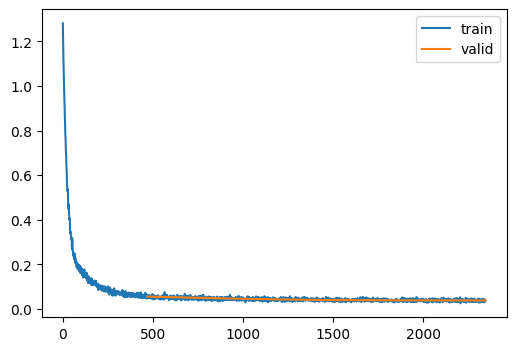

In [38]:
# Trying to replicate whats been happening in Tanishks notebook.
learner.fit(epochs)

In [39]:
torch.save(learner.model, mdl_path/'fashion_ddpm_v2.pkl')

In [45]:
learner.model = torch.load(mdl_path/'fashion_ddpm_v2.pkl')

In [46]:
samples, x0_c, xt_c = ddpm_cb.sample(learner.model, (16, 1, 32, 32))

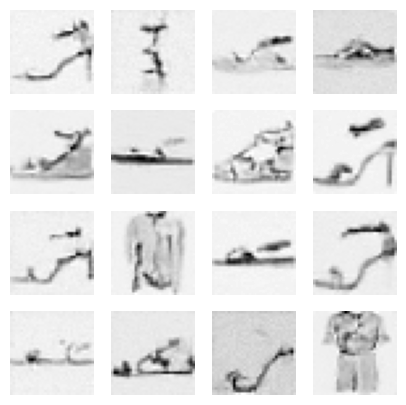

In [47]:
show_images(-samples[-1], figsize=(5,5))

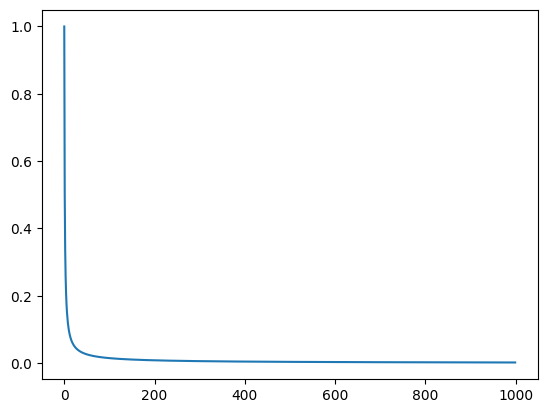

In [52]:
plt.plot(list(reversed(x0_c)))

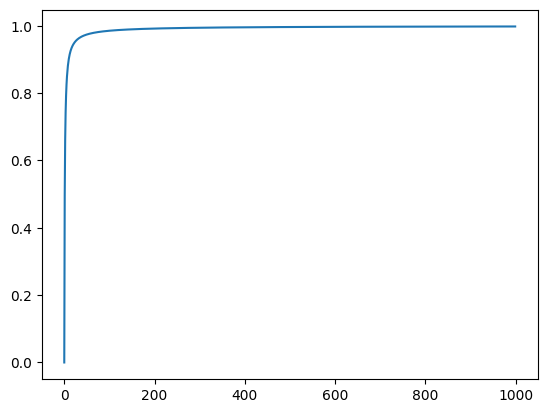

In [51]:
plt.plot(list(reversed(xt_c)))

# Plotting for better understanding.

In [ ]:
fracs = []
for i in range(len(cbs[-3].beta) - 1):
  fracs.append(cbs[-3].beta[i]/cbs[-3].beta[i+1])

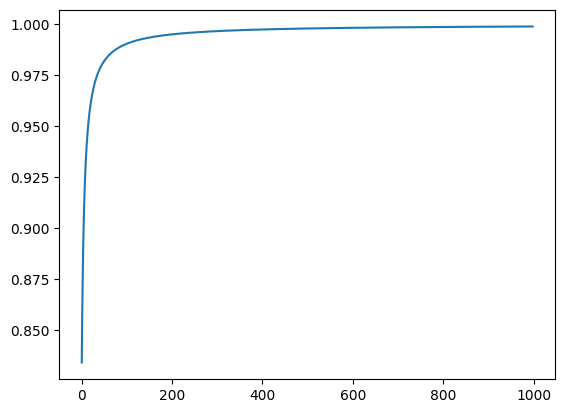

In [ ]:
plt.plot(fracs)

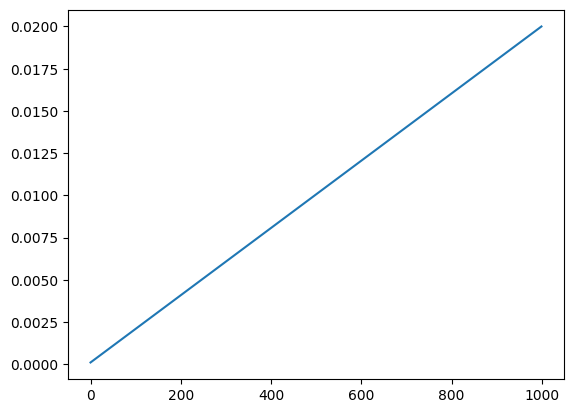

In [ ]:
plt.plot(cbs[-3].beta)

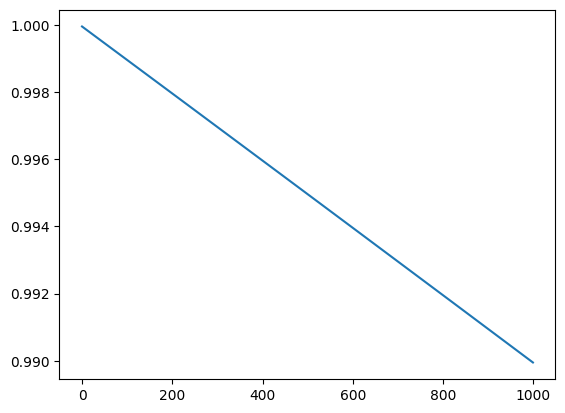

In [ ]:
plt.plot(cbs[-3].alpha.sqrt())

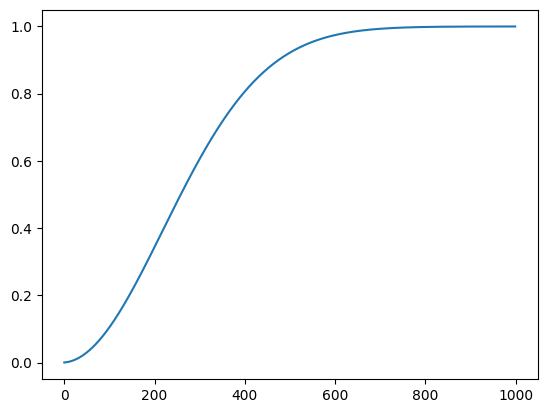

In [ ]:
plt.plot((1 - cbs[-3].alpha_bar))

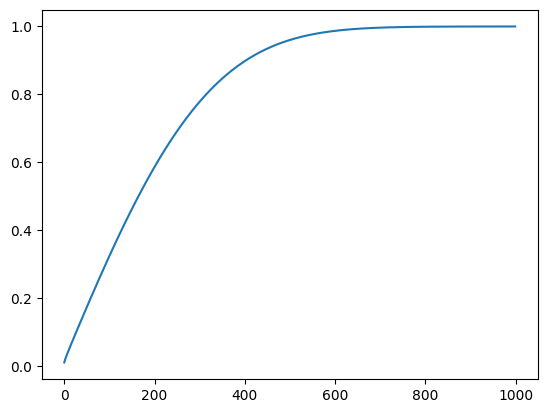

In [ ]:
plt.plot((1 - cbs[-3].alpha_bar).sqrt())

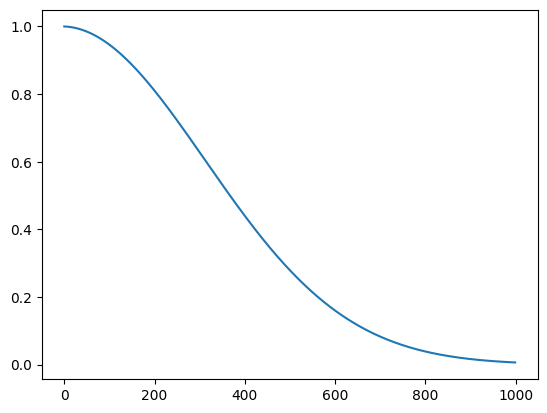

In [ ]:
plt.plot(cbs[-3].alpha_bar.sqrt())

In [ ]:
o = cbs[-3]
dist = []
for i in range(1, len(o.alpha_bar)):
  dist.append(o.alpha_bar[i - 1].sqrt()*o.beta[i]/(1 - o.alpha_bar[i]))


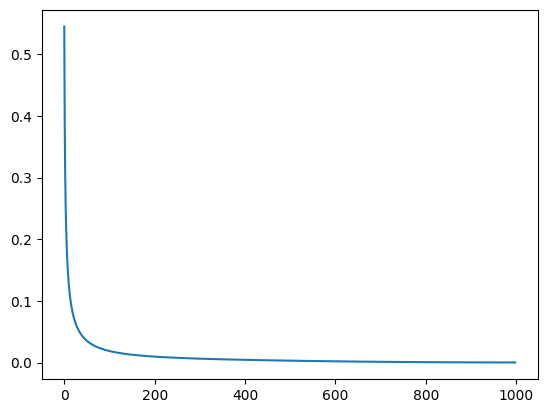

In [ ]:
plt.plot(dist)

# Error Fixing in Generating Sample code


In [ ]:
learner.model.device

device(type='cuda', index=0)

In [ ]:
x_t = torch.randn((1, 32, 32)).to(model.device)
x_t[None, :].shape

torch.Size([1, 1, 32, 32])

In [55]:
!pip install tqdm
from tqdm import tqdm

In [71]:
@torch.no_grad()
def sample(model = learner.model, cb = DDPMPrep(), out_shape = (16, 1, 32, 32)):
  preds, x0_coeffs, xt_coeffs = [], [], []
  n_steps, beta, alpha, alpha_bar, sigma = cb.n_steps, cb.beta.to(model.device), cb.alpha.to(model.device), cb.alpha_bar.to(model.device), cb.sigma.to(model.device)
  x_t = torch.randn(out_shape).to(model.device)
  for ts in tqdm(reversed(range(n_steps))):
    t_batch = torch.full((out_shape[0],), ts, device = model.device, dtype = torch.long)#torch.stack([torch.tensor([ts], device = model.device, dtype = torch.long)] * out_shape[0], dim = 0)
    noise_pred = model((x_t, t_batch))

    z = (torch.randn(x_t.shape) if ts > 0 else torch.zeros(x_t.shape)).to(model.device)
    alpha_bar_t_1 = alpha_bar[ts - 1] if ts > 0 else torch.tensor(1.)
    beta_bar_t = 1 - alpha_bar[ts]
    beta_bar_t_1 = 1 - alpha_bar_t_1
    alpha_bar_t = alpha_bar[ts]

    x0_hat = ((x_t - beta_bar_t.sqrt()*noise_pred)/(alpha_bar_t.sqrt())).clamp(-1, 1)
    # ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t
    x0_coeff = alpha_bar_t_1.sqrt() * (1 - alpha[ts])/beta_bar_t
    xt_coeff = alpha[ts].sqrt()*beta_bar_t_1/beta_bar_t

    x_t = x0_hat*x0_coeff + xt_coeff*x_t + sigma[ts]*z

    preds.append(x_t.cpu())
    x0_coeffs.append(x0_coeff.cpu())
    xt_coeffs.append(xt_coeff.cpu())

  return preds, x0_coeffs, xt_coeffs



In [68]:
torch.full((16,), 23)

tensor([23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23])

In [75]:
learner.model = torch.load(mdl_path/'fashion_ddpm.pkl')
out = sample(model = learner.model)

1000it [00:30, 33.14it/s]


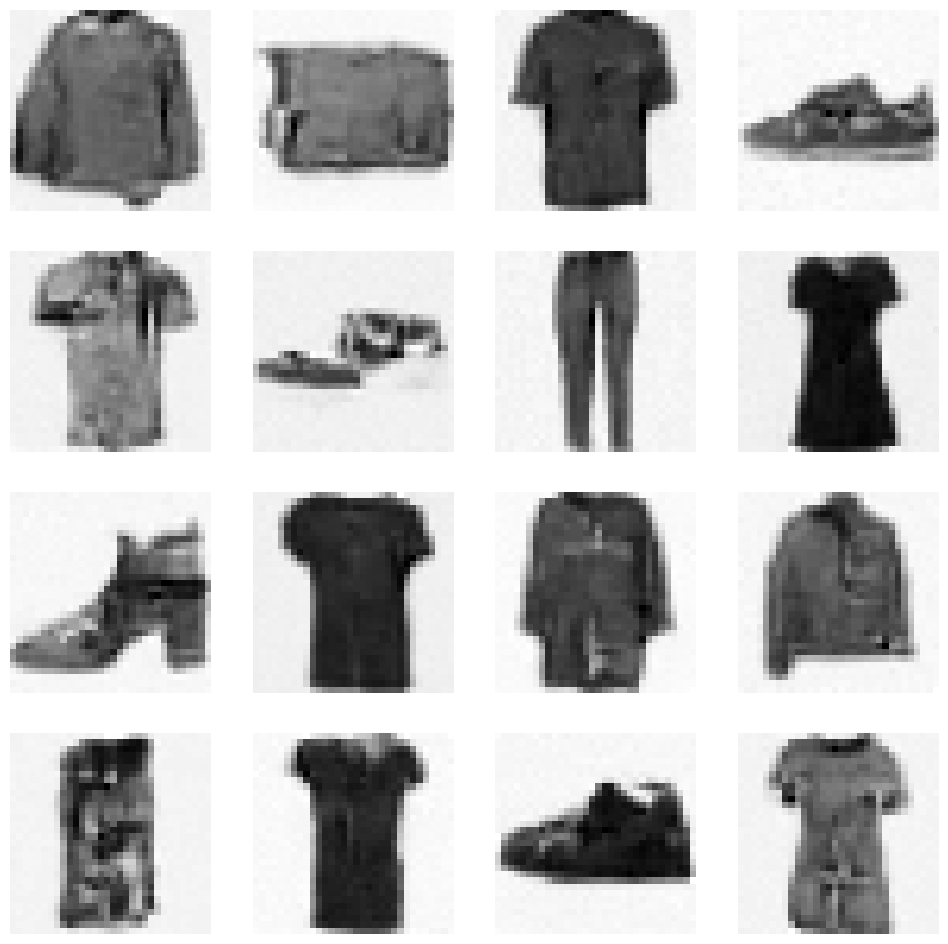

In [76]:
show_images(-out[0][-1])

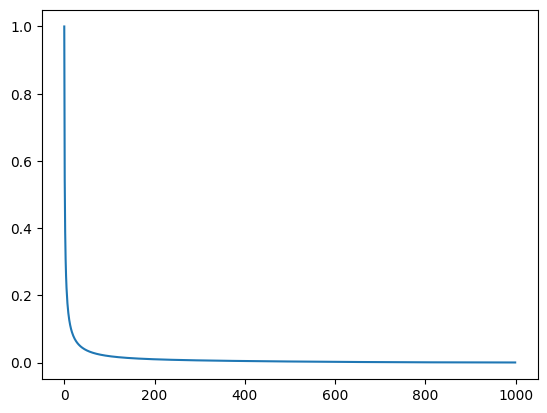

In [63]:
plt.plot(list(reversed(out[1])))

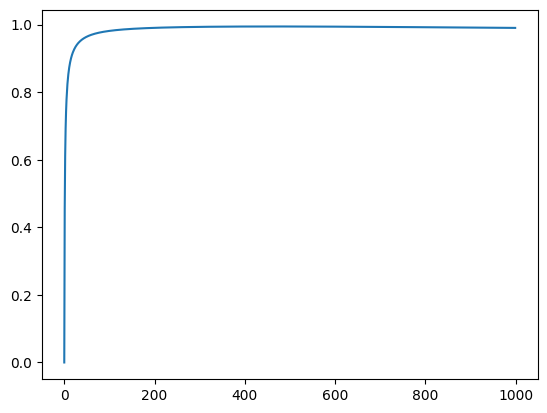

In [62]:
plt.plot(list(reversed(out[2])))

In [77]:
samples = out[0]

In [78]:
%matplotlib auto
import matplotlib.animation as animation
from IPython.display import display, HTML
from fastcore.foundation import L

fig,ax = plt.subplots(figsize=(3,3))
def _show_i(i): return show_image(-samples[i][9], ax=ax, animated=True).get_images()
r = L.range(800,990, 5)+L.range(990,1000)+[999]*10
ims = r.map(_show_i)

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=3000)
display(HTML(animate.to_html5_video()))


Using matplotlib backend: <object object at 0x7e31bb7a7660>
